# Changes

This notebook makes the NN take in an activation function as input, to compare different activation functions

In [152]:
import pandas as pd

Using the actual dataset from the matlab file given instead.

In [153]:
import pandas as pd
import os

In [154]:
data_path = "original_dataset/matlab_file_sorted.csv" #Windows
df = pd.read_csv(data_path)
y = df["label"]
X = df.drop(columns=["label"])

In [155]:
X.head(), y.head(), 

(           0          1       2    3        4      5        6       7  \
 0  326.80817   2.686124   5.556  0.0   5.7600  0.000   5.9470  0.0000   
 1  321.20044  25.880459   0.000  0.0   7.6116  0.001   0.0000  0.0000   
 2  144.03845 -12.459262  10.512  0.0  10.6920  0.000  10.8660  0.0000   
 3  209.66217  21.696203   0.000  0.0   0.0000  0.000   6.8603  0.1042   
 4   65.16255 -20.639620   0.000  0.0   0.0000  0.000   6.3206  0.0000   
 
          8       9  ...     16     17     18     19      20      21      22  \
 0   6.0720  0.0000  ...  0.162  0.050  0.015  0.044   5.562   5.539   5.479   
 1   7.5167  0.0010  ...  0.059  0.020  0.016  0.059   6.896   6.921   6.932   
 2  10.9890  0.0000  ...  0.022  0.020  0.074  0.000  10.408  10.400  10.378   
 3   0.0000  0.0000  ...  0.149  0.046  0.015  0.037   5.671   5.717   5.704   
 4   5.9504  0.0031  ...  0.169  0.072  0.015  0.036   5.430   5.402   5.333   
 
       23     24     25  
 0  0.017  0.026  0.020  
 1  0.026  0.024  0.

Generating fictive data

In [156]:
from imblearn.combine import SMOTEENN

# testing 

smote_enn = SMOTEENN(random_state=42)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)

In [163]:
from sklearn.model_selection import train_test_split
X_train,  X_test, y_train,y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

Scale the data with respect to the training data X_train

In [164]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [165]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)

pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [166]:
import numpy as np
y_train, y_test = np.array(y_train), np.array(y_test)

In [167]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape   

((4694, 5), (1174, 5), (4694,), (1174,))

Neural Net for binary classification 5x64x32x1

# NN

In [168]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader



# Convert numpy arrays or pandas DataFrames to PyTorch tensors if needed
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)

# Defining a simple neural network class for binary classification
class NeuralNet(nn.Module):
    def __init__(self, input_size, activation):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.activation = activation       # Arbitrary activation function
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 32)  
        self.fc4 = nn.Linear(32, 1)# Output layer with single neuron (binary classification)

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))  # Apply sigmoid activation for binary classification of final output
        return x


The training loop

In [177]:
import os

activation_functions = [nn.ReLU(), nn.Sigmoid(), nn.Tanh(), nn.Hardtanh()]
act_colors = {"ReLU": "red", "Sigmoid": "blue", "Tanh": "green", "Hardtanh": "orange"}
losses = [] #Might turn into dict to make it more readable
for activation in activation_functions:
    print(f"Training with activation function: {activation}")
    # Initialize the neural network
    input_size = X_train.shape[1]
    model = NeuralNet(input_size, activation)

    # Define loss function and optimizer
    criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
    optimizer = optim.Adam(model.parameters())

    # Prepare data for training using DataLoader
    batch_size = 32
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    num_epochs = 15
    temp_loss = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            outputs = outputs.squeeze(dim=1)  # Remove extra dimension for binary classification
            loss = criterion(outputs, labels.float())  # Calculate loss

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        # Print average loss per epoch
        print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader)}")
        temp_loss.append(running_loss / len(train_loader))
    losses.append(temp_loss)

    # Example: Make predictions
    # Assuming X_test is your test data
    X_test = torch.tensor(X_test, dtype=torch.float32)
    model.eval()  # Switch to evaluation mode
    with torch.no_grad():
        predictions = model(X_test)
        predictions = (predictions > 0.5).int()  # Convert probabilities to binary predictions (0 or 1)

    # Define the directory path
    dir_path = './models/activation_test/'
    
    # Check if the directory exists
    if not os.path.exists(dir_path):
        # If not, create the directory
        os.makedirs(dir_path)

    #Saving model for later use
    model_dir = './models/activation_test'
    os.makedirs(model_dir, exist_ok=True)  # Create directory if it doesn't exist
    model_path = os.path.join(model_dir, f'{type(activation).__name__}_binary_classification_model.pth')
    torch.save(model.state_dict(), model_path)

Training with activation function: ReLU()
Epoch 1, Loss: 0.49380332353163736
Epoch 2, Loss: 0.345119247428414
Epoch 3, Loss: 0.2886784162853851
Epoch 4, Loss: 0.26262298312519683
Epoch 5, Loss: 0.24308719116003336
Epoch 6, Loss: 0.23000904512243206
Epoch 7, Loss: 0.22209814241548784
Epoch 8, Loss: 0.21696254676904808
Epoch 9, Loss: 0.21390794417789194
Epoch 10, Loss: 0.21063947956375526
Epoch 11, Loss: 0.2015625065585383
Epoch 12, Loss: 0.19913443112048973
Epoch 13, Loss: 0.1940485309986841
Epoch 14, Loss: 0.1920952017919547
Epoch 15, Loss: 0.19102064188138967
Training with activation function: Sigmoid()


C:\Users\iver_y\AppData\Local\Temp\ipykernel_33700\1464925698.py:48: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test, dtype=torch.float32)


Epoch 1, Loss: 0.6482028476640481
Epoch 2, Loss: 0.49845820097696214
Epoch 3, Loss: 0.47675687358492896
Epoch 4, Loss: 0.4735472548981102
Epoch 5, Loss: 0.4703476889198329
Epoch 6, Loss: 0.4687068371140227
Epoch 7, Loss: 0.46712195488060415
Epoch 8, Loss: 0.46490535950985085
Epoch 9, Loss: 0.45941900517664797
Epoch 10, Loss: 0.45368789085725536
Epoch 11, Loss: 0.44395939093463277
Epoch 12, Loss: 0.43405329593184855
Epoch 13, Loss: 0.4238046851693367
Epoch 14, Loss: 0.417311523236385
Epoch 15, Loss: 0.40712992198207754
Training with activation function: Tanh()
Epoch 1, Loss: 0.5024241474615473
Epoch 2, Loss: 0.4228506762356985
Epoch 3, Loss: 0.34880497828632795
Epoch 4, Loss: 0.3093753338468318
Epoch 5, Loss: 0.28407870724695883
Epoch 6, Loss: 0.26405495045339167
Epoch 7, Loss: 0.25588951776830515
Epoch 8, Loss: 0.2462852796932467
Epoch 9, Loss: 0.2374695522748694
Epoch 10, Loss: 0.23019428642428652
Epoch 11, Loss: 0.23001347360562305
Epoch 12, Loss: 0.22212319854064053
Epoch 13, Loss: 

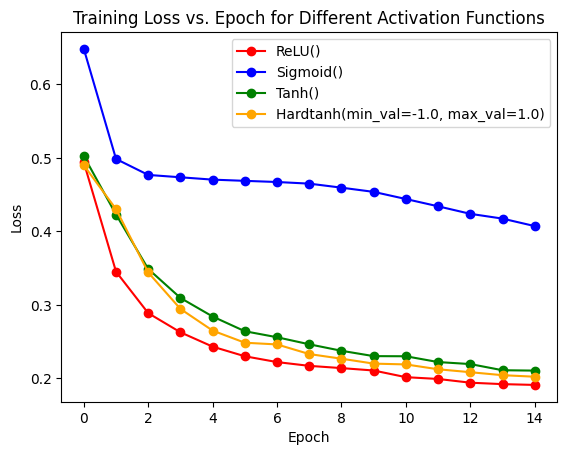

In [178]:
import matplotlib.pyplot as plt
for i, loss in enumerate(losses):
    c = act_colors[type(activation_functions[i]).__name__]
    plt.plot(loss, "-o", label=str(activation_functions[i]), color = c)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs. Epoch for Different Activation Functions")
plt.show()

Testing on the training set

In [172]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, confusion_matrix

for activation in activation_functions:
    print(f"Evaluating model with activation function: {activation}")
    # Load the trained model
    input_size = input_size  # Assuming the input size based on X_train
    model = NeuralNet(input_size, activation)
    # model.load_state_dict(torch.load('./models/binary_classification_model.pth'))  # Load the trained model state  (Windows)
    model.load_state_dict(torch.load('models/activation_test/'+type(activation).__name__+'_binary_classification_model.pth'))  # Load the trained model state (MACos)


    # Assuming X_test and y_test are your test data
    X_train = X_train.float()
    y_train = torch.tensor(y_train, dtype=torch.float32)

    # Prepare test dataset and dataloader
    batch_size = 64
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle for testing

    # Evaluate the model on the test set using F1 score
    model.eval()  # Switch to evaluation mode
    y_true = []
    y_pred = []
    #print(test_loader)
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate Matthews Correlation Coefficient (MCC)
    mcc_tr = matthews_corrcoef(y_true, y_pred)

    

    print(f"Training: MCC-score: {mcc_tr}, check against the test set for overfitting")


Evaluating model with activation function: ReLU()
Training: MCC-score: 0.8614867772242706, check against the test set for overfitting
Evaluating model with activation function: Sigmoid()


C:\Users\iver_y\AppData\Local\Temp\ipykernel_33700\1797312987.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)
C:\Users\iver_y\AppData\Local\Temp\ipykernel_33700\1797312987.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


Training: MCC-score: 0.6285649576350745, check against the test set for overfitting
Evaluating model with activation function: Tanh()


C:\Users\iver_y\AppData\Local\Temp\ipykernel_33700\1797312987.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


Training: MCC-score: 0.8321274331804749, check against the test set for overfitting
Evaluating model with activation function: Hardtanh(min_val=-1.0, max_val=1.0)
Training: MCC-score: 0.8506912368922177, check against the test set for overfitting


C:\Users\iver_y\AppData\Local\Temp\ipykernel_33700\1797312987.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


Testing the model on the test set

In [173]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, confusion_matrix


all_metrics = {}
all_confusion_matrices = {}
for activation in activation_functions:
    print(f"Evaluating model with activation function: {activation}")
    # Load the trained model
    input_size = input_size  # Assuming the input size based on X_train
    model = NeuralNet(input_size, activation)
    # model.load_state_dict(torch.load('./models/binary_classification_model.pth'))  # Load the trained model state  (Windows)
    model.load_state_dict(torch.load('models/activation_test/'+type(activation).__name__+'_binary_classification_model.pth'))  # Load the trained model state (MACos)


    # Assuming X_test and y_test are your test data
    X_test = X_test.float()
    y_test = torch.tensor(y_test, dtype=torch.float32)

    # Prepare test dataset and dataloader
    batch_size = 64
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No need to shuffle for testing

    # Evaluate the model on the test set using F1 score
    model.eval()  # Switch to evaluation mode
    y_true = []
    y_pred = []
    #print(test_loader)
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predicted = (outputs > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred)
    #print(f"F1 Score: {f1}")

    # Calculate Matthews Correlation Coefficient (MCC)
    mcc = matthews_corrcoef(y_true, y_pred)
    #print("Matthews Correlation Coefficient (MCC):", mcc)

    # Compute accuracy, precision and recall
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='binary')  # Change average as needed
    recall = recall_score(y_true, y_pred, average='binary')  # Change average as needed

    #print("Accuracy:", accuracy)
    #print("Precision:", precision)
    #print("Recall:", recall)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    #print("Confusion Matrix:", conf_matrix)

    # Store the metrics in a dictionary for easy plotting
    metrics = {'F1 Score': f1, 'MCC': mcc, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall}
    
    all_metrics[type(activation).__name__] = metrics
    all_confusion_matrices[type(activation).__name__] = conf_matrix
    print(f"Testing: {metrics['MCC']}")

    # Define the directory path
    dir_path = './models/activation_test/'
    
    # Check if the directory exists
    if not os.path.exists(dir_path):
        # If not, create the directory
        os.makedirs(dir_path)

    # Save the model
    model_path = os.path.join(dir_path, type(activation).__name__+'_binary_classification_model.pth')
    torch.save(model.state_dict(), model_path)

Evaluating model with activation function: ReLU()
Testing: 0.8566597410423354
Evaluating model with activation function: Sigmoid()


C:\Users\iver_y\AppData\Local\Temp\ipykernel_33700\2081078569.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


Testing: 0.6271850442887416
Evaluating model with activation function: Tanh()
Testing: 0.8144598687980722
Evaluating model with activation function: Hardtanh(min_val=-1.0, max_val=1.0)
Testing: 0.8615236035923854


C:\Users\iver_y\AppData\Local\Temp\ipykernel_33700\2081078569.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)
C:\Users\iver_y\AppData\Local\Temp\ipykernel_33700\2081078569.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


{'ReLU': 'red', 'Sigmoid': 'blue', 'Tanh': 'green', 'Hardtanh': 'orange'}


(0.6, 1.0)

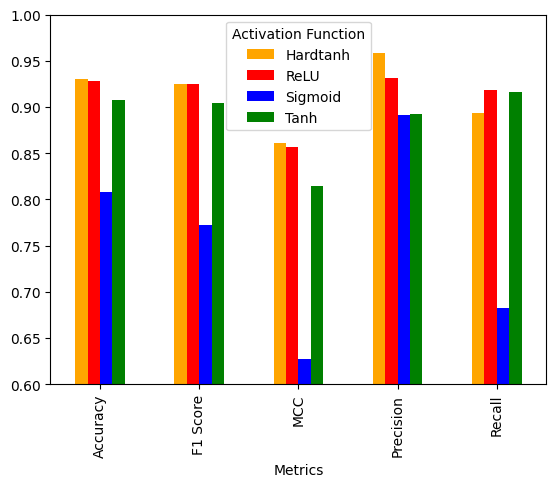

In [192]:
# Convert the all_metrics dictionary to a DataFrame
data = pd.DataFrame(all_metrics)
# Reset the index to make 'Metrics' a column
data = data.reset_index().rename(columns={'index': 'Metrics'})


data = pd.melt(data, id_vars='Metrics', var_name='Activation Function', value_name='Value')

data = data.set_index(['Metrics', 'Activation Function']).Value
# colors = [act_colors[act_name] for act_name in all_metrics.keys()]
colors = ["orange", "red", "blue", "green"]
data.unstack().plot(kind='bar', stacked=False, color = colors)
plt.ylim(0.6,1)

## Confusion matrix comparison

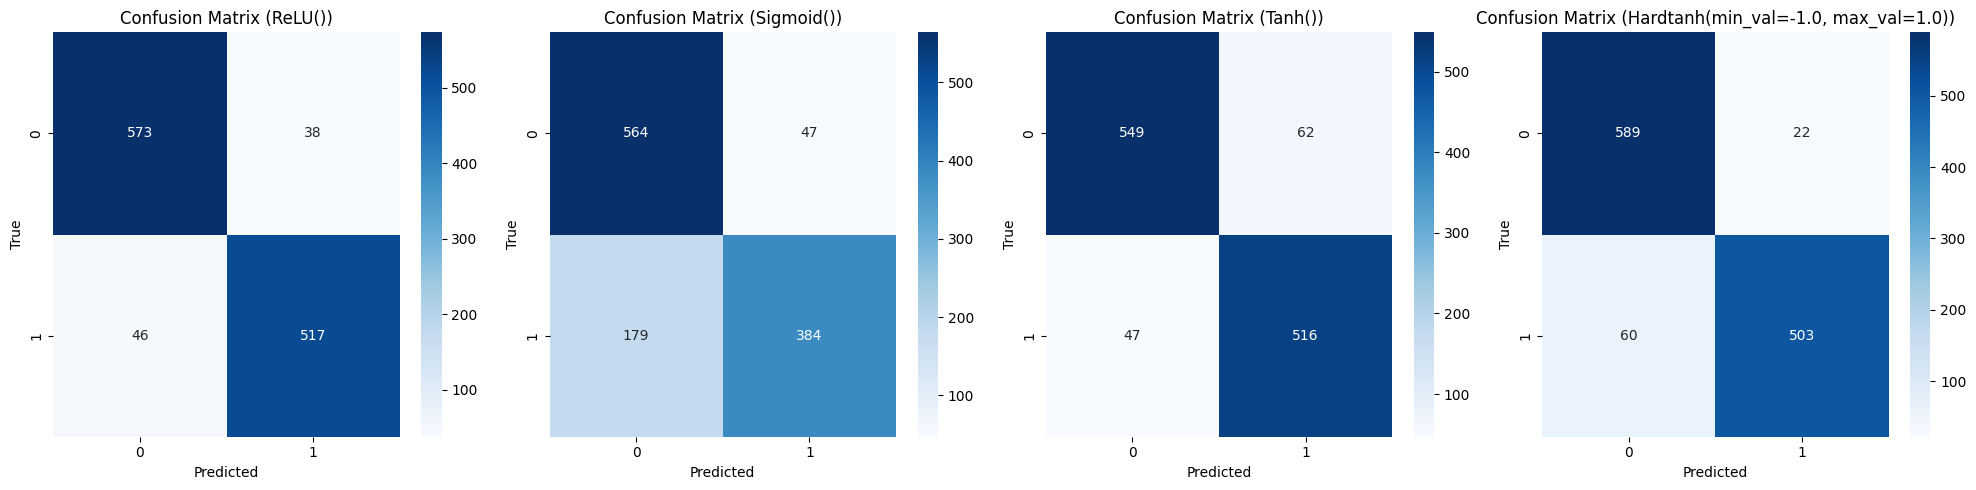

In [175]:
import seaborn as sns

fig, axes = plt.subplots(1, len(activation_functions), figsize=(20, 5))

for i, activation in enumerate(activation_functions):
    # Assume you have a function `get_conf_matrix` that returns the confusion matrix for a given activation function
    conf_matrix = all_confusion_matrices[type(activation).__name__]

    # Create a heatmap for the confusion matrix on the i-th subplot
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[i])

    # Set the title, x-label, and y-label for the i-th subplot
    axes[i].set_title(f'Confusion Matrix ({activation})')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()

Kanskje velge Hardtan over Relu, siden FN ikke er så viktig, det var fra før av vanskelig å oppdage brune dverger, mens TP og FP er viktigere, unødvendig å mappe masse vanlige soler til brune dverger
